In [89]:
from unstructured.documents.elements import Table, Image

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

In [9]:
from unstructured.partition.pdf import partition_pdf

output_path = "./data/raw/"
file_path = output_path + 'Sirocco - Linha Conforto.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image","Table"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="basic",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=2000,
    languages=["por","eng"],
    ocr_languages=["por","eng"]

    # extract_images_in_pdf=True,          # deprecated
)

The ocr_languages kwarg will be deprecated in a future version of unstructured. Please use languages instead.


In [10]:
# Mostra quantos elementos foram extraídos
print(f"Total de elementos extraídos: {len(chunks)}\n")

# Mostra os primeiros elementos
for i, chunk in enumerate(chunks[:5]):
    print(f"\n--- Chunk {i+1} ---")
    print(f"Tipo: {type(chunk)}")
    print(f"Texto:\n{chunk.text}")

Total de elementos extraídos: 11


--- Chunk 1 ---
Tipo: <class 'unstructured.documents.elements.CompositeElement'>
Texto:
Índice

Dimensionais

Modelo Sirocco

CSD 160 a 710 – Arr. 3 – Dimensões Gerais Pag. 2 CSD 160 a 710 – Arr. 3 – Dimensões com Base Única Pag. 3 CSD 800 a 1250 – Arr. 3 – Dimensões Gerais Pag. 4 CSD 800 a 1250 – Arr. 3 – Dimensões com Base Única Pag. 5 CSS 160 a 710 – Arr. 3 - Dimensões Gerais Pag. 6 CSS 160 a 710 – Arr. 3 - Dimensões com Base Única Pag. 7 CSS 800 a 1250 – Arr. 3 - Dimensões Gerais Pag. 8 CSS 800 a 1250 – Arr. 3 - Dimensões com Base Única Pag. 9 CSS 180 a 710 – Arr. 1 – Dimensões Gerais Pag. 10 CSS 180 a 710 – Arr. 1 – Dimensões com Base Única Pag. 11 CSS 280 a 710 – Arr. 9 - Dimensões Gerais Pag. 12 CSS 280 a 710 – Arr. 9 - Dimensões com Trilhos Pag. 13 CSS 160 a 355 – Arr. 4 – Dimensões Gerais Pag. 14 CSS 160 a 355 – Arr. 4 – Dimensões Complementares Pag. 15 CSS 400 a 710 – Arr. 4 – Dimensões Gerais Pag. 16 CSS 400 a 710 – Arr. 4 – Dimensões com T

In [4]:
with open("conteudo_extraido.txt", "w", encoding="utf-8") as f:
    for chunk in chunks:
        f.write(chunk.text + "\n\n")

In [5]:
for chunk in chunks:
    print(type(chunk), "-", chunk.text[:80])

In [6]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

set()

In [11]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[0].metadata.orig_elements

In [12]:
from collections import Counter

# Conta os tipos dos elementos dentro do primeiro chunk
tipo_elementos = Counter(type(el).__name__ for el in chunks[0].metadata.orig_elements)
print(tipo_elementos)

Counter({'Image': 3, 'Title': 3, 'Table': 3, 'NarrativeText': 1, 'Header': 1, 'Text': 1})


In [13]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '27d84e49-54b1-4384-9eea-6286b90f1fa3',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(1087.6666666666667),
     np.float64(212.66555555555567)),
    (np.float64(1087.6666666666667), np.float64(322.9988888888891)),
    (np.float64(1475.0), np.float64(322.9988888888891)),
    (np.float64(1475.0), np.float64(212.66555555555567))),
   'system': 'PixelSpace',
   'layout_width': 1653,
   'layout_height': 2339},
  'last_modified': '2023-09-01T11:56:36',
  'filetype': 'PPM',
  'languages': ['por', 'eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABuAYMDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZW

In [ ]:
from unstructured.documents.elements import Table, Image
import base64
from PIL import Image as PILImage
from io import BytesIO
import pytesseract

def ocr_b64(b64, lang="por+eng"):
    try:
        # Se vier com prefixo data:, remove
        if b64.startswith("data:image"):
            b64 = b64.split(",", 1)[1]
        img = PILImage.open(BytesIO(base64.b64decode(b64)))
        text = pytesseract.image_to_string(img, lang=lang)
        return text.strip()
    except Exception:
        return ""

def harvest_blocks(chunks, min_text_len=10):
    texts = []           # strings de texto
    tables_html = []     # tabelas em HTML (quando houver)
    ocr_texts = []       # textos via OCR
    images_b64 = []      # imagens em base64

    for ch in chunks:
        # ---------- TABELA ----------
        if isinstance(ch, Table):
            html = getattr(getattr(ch, "metadata", None), "text_as_html", None)
            if html and len(html) > min_text_len:
                tables_html.append(html)
            else:
                # tentar OCR em imagens associadas
                origs = getattr(getattr(ch, "metadata", None), "orig_elements", None) or []
                got_ocr = False
                for el in origs:
                    if isinstance(el, Image):
                        b64 = getattr(getattr(el, "metadata", None), "image_base64", None)
                        if b64:
                            txt = ocr_b64(b64)
                            if txt:
                                ocr_texts.append(txt)
                                images_b64.append(b64)
                                got_ocr = True
                # fallback: se não rolou OCR mas há html (curto), guarda mesmo assim
                if not got_ocr and html:
                    tables_html.append(html)

        # ---------- IMAGEM PURA ----------
        elif isinstance(ch, Image):
            b64 = getattr(getattr(ch, "metadata", None), "image_base64", None)
            if b64:
                images_b64.append(b64)
                txt = ocr_b64(b64)
                if txt:
                    ocr_texts.append(txt)

        # ---------- TEXTO (qualquer elemento com .text) ----------
        elif hasattr(ch, "text"):
            t = getattr(ch, "text", "") or ""
            if len(t) >= min_text_len:
                texts.append(t)
            # varrer imagens embutidas nesse bloco
            origs = getattr(getattr(ch, "metadata", None), "orig_elements", None) or []
            for el in origs:
                if isinstance(el, Image):
                    b64 = getattr(getattr(el, "metadata", None), "image_base64", None)
                    if b64:
                        images_b64.append(b64)
                        # OCR sob demanda: se o texto do bloco for curto
                        if len(t) < min_text_len:
                            txt = ocr_b64(b64)
                            if txt:
                                ocr_texts.append(txt)

        # ---------- OUTROS TIPOS ----------
        else:
            # tenta extrair um texto “genérico”
            t = getattr(ch, "text", None) or getattr(ch, "page_content", None)
            if t and len(t) > min_text_len:
                texts.append(t)

    return {
        "texts": texts,
        "tables_html": tables_html,
        "ocr_texts": ocr_texts,
        "images_b64": images_b64,
    }


In [14]:
elements = harvest_blocks(chunks)

texts       = elements["texts"]              # lista de strings
tables      = elements["tables_html"]             # lista de dicts {"text":..., "html":...}
ocr_texts   = elements['ocr_texts']
images_b64  = elements["images_b64"]         # lista de base64
print(len(texts), len(tables),len(ocr_texts), len(images_b64))

NameError: name 'harvest_blocks' is not defined

In [20]:
from unstructured.documents.elements import Table, Image

tables, texts, images = [], [], []

for ch in chunks:
    # Tabela “pura”
    if isinstance(ch, Table):
        tables.append(ch)

    # Tabelas aninhadas
    if hasattr(ch.metadata, "orig_elements") and ch.metadata.orig_elements:
        for el in ch.metadata.orig_elements:
            if isinstance(el, Table):
                tables.append(el)
            if isinstance(el, Image) and getattr(el.metadata, "image_base64", None):
                images.append(el.metadata.image_base64)

    # Texto
    if "CompositeElement" in str(type(ch)):
        texts.append(ch)

In [21]:
tables

In [17]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [18]:
print(type(chunks[1]))

<class 'unstructured.documents.elements.CompositeElement'>


In [19]:
print(tables)

[]


In [23]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

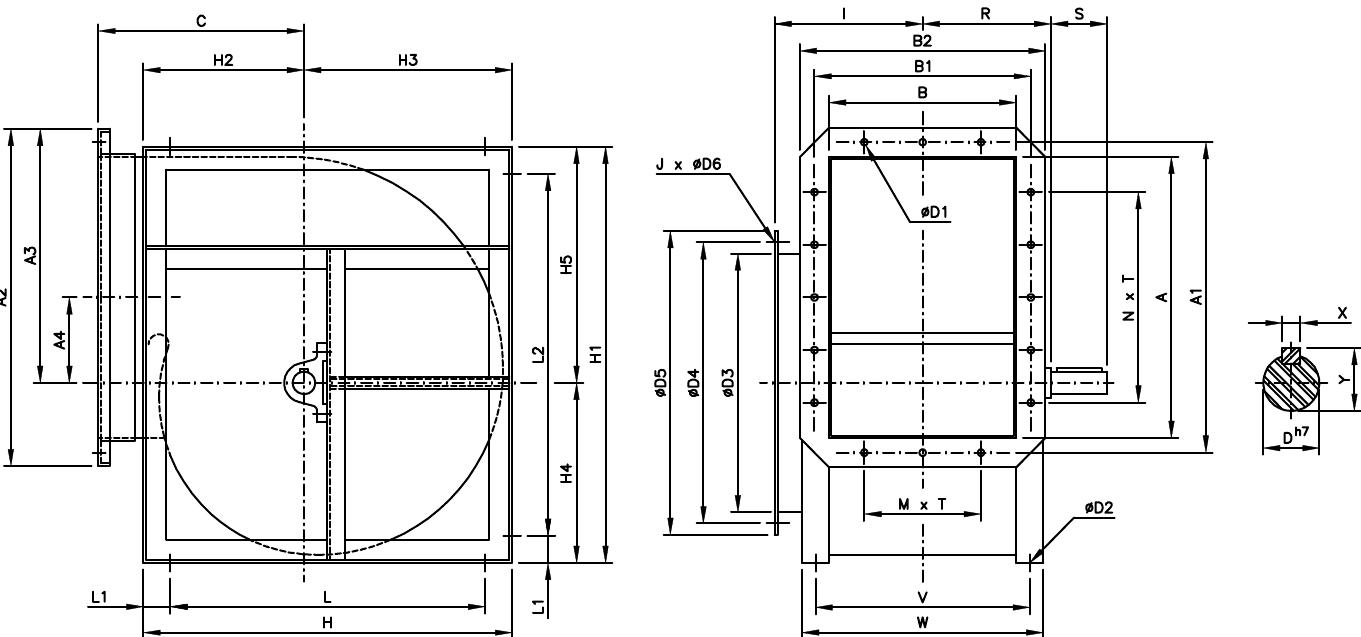

In [24]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[12])

In [25]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [26]:
# Prompt
prompt_text = """
You are an assistant. If the input is a question, answer it clearly and concisely.
If the input is a piece of text or table, summarize it.

Input:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(api_key=groq_api_key,temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [27]:
import time
from langchain_core.runnables import Runnable
from typing import List

def safe_batch_process(chain: Runnable, data: List[str], batch_size=1, wait_on_error=10):
    results = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        try:
            batch_results = chain.batch(batch, {"max_concurrency": 2})
            results.extend(batch_results)
        except Exception as e:
            print(f"⏱️ Rate limit atingido ou erro: {e}")
            print(f"🔁 Esperando {wait_on_error} segundos para tentar de novo...")
            time.sleep(wait_on_error)
            # tenta o mesmo batch de novo
            try:
                batch_results = chain.batch(batch, {"max_concurrency": 2})
                results.extend(batch_results)
            except Exception as e2:
                print(f"❌ Ainda deu erro: {e2} — pulando esse batch.")
    return results


In [28]:
text_summaries = safe_batch_process(summarize_chain, texts)

In [29]:
text_summaries

['This appears to be a technical document related to the dimensions and specifications of a product, likely a machine or equipment, known as "Sirocco". The document is organized by model numbers and includes various dimensions and measurements for different components.\n\nHere\'s a summary of the document:\n\n* The document covers various models of the Sirocco product, including CSD, CSS, and others.\n* Each model has multiple dimensions and measurements listed, including ØD (diameter), ØD2, M, A, B, C, E, F, G, H, H3, H4, H5, L, R, S, V, W, X, Y, and Z.\n* The dimensions and measurements are listed in tables for each model, with different columns representing different components or features.\n* The document also includes a note at the end, stating that the manufacturer reserves the right to make changes without prior notice.\n\nThe document appears to be a technical manual or specification sheet for the Sirocco product, and may be used by engineers, technicians, or other professional

In [30]:
table_summaries = safe_batch_process(summarize_chain, tables)

In [31]:
table_summaries

['The input appears to be a list of page numbers and corresponding topics related to dimensions, possibly from a catalog or manual. Here\'s a summarized version:\n\nThe document contains information on dimensions for various products, including:\n\n- CSD and CSS products with different size ranges and arrangements (e.g., CSD 160 a 710, CSS 160 a 355)\n- General dimensions and dimensions with base unique or with trilhos (rails)\n- Products with specific arrangement numbers (e.g., Arr. 1, Arr. 3, Arr. 4, Arr. 9)\n- A product referred to as "Cota \'K\'" with base unique dimensions\n\nThe document spans 20 pages, covering various aspects of product dimensions.',
 "This appears to be a table with multiple columns. However, it's not clear what the table represents or what its columns signify. \n\nIf we look at the table, we can see that it has two main parts - one with numerical data (A, B, C, D, E, F, G) and the other with what seems to be labels (H3, H4).\n\nHere's a possible breakdown of 

In [32]:
from PIL import Image
from io import BytesIO
import base64
import pytesseract

def ocr_from_images_base64(images_b64):
    image_texts = []
    for b64 in images_b64:
        try:
            image_data = base64.b64decode(b64)
            image = Image.open(BytesIO(image_data))
            text = pytesseract.image_to_string(image, lang="por+eng")
            image_texts.append(text)
        except Exception as e:
            print(f"❌ Erro ao processar imagem: {e}")
    return image_texts

ocr_texts = ocr_from_images_base64(images)

In [33]:
# Prompt com variável {element}
prompt_text_image = """
The following is OCR-extracted text from an image found in a technical document.

Describe in detail what the image is likely showing, based on the text.
Be specific about diagrams, graphs, or bar plots if relevant.

OCR text:
{element}
"""

prompt_image = ChatPromptTemplate.from_template(prompt_text_image)

# Agora sim, o chain está coerente
summarize_chain = {"element": lambda x: x} | prompt_image | model | StrOutputParser()

In [34]:
image_summaries = safe_batch_process(summarize_chain, ocr_texts)

In [35]:
image_summaries

["I'm ready to help, but it seems like you didn't provide the OCR-extracted text from the image. Please paste the text so I can assist you in describing what the image is likely showing.",
 "I don't see any OCR text provided. Please paste the text extracted from the image, and I'll be happy to help you describe what the image is likely showing.",
 'Based on the OCR-extracted text, it appears that the image is likely a graph or a chart, possibly a bar plot or a histogram. Here\'s a breakdown of the possible components:\n\n- The numbers "902" and "pt" are likely labels or values on the y-axis or the title of the graph, possibly indicating the scale or the unit of measurement.\n- The horizontal line with a single dot or a small mark above it might represent a specific value or a threshold on the graph.\n- The series of vertical lines (indicated by the "i" characters) and the "|" character might represent the x-axis or the categories on the graph.\n- The "B" and "1" characters might be lab

In [36]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.embeddings import HuggingFaceEmbeddings

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embedding_function)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

C:\Users\Orçamento\AppData\Local\Temp\ipykernel_16372\3101373717.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
C:\Users\Orçamento\AppData\Local\Temp\ipykernel_16372\3101373717.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", em

In [37]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts))),

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)]
#retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [38]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)
print(docs)

[<unstructured.documents.elements.CompositeElement object at 0x000001F08AD9E660>, <unstructured.documents.elements.CompositeElement object at 0x000001F0989CFBC0>, <unstructured.documents.elements.CompositeElement object at 0x000001F0989CED20>, '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMiBVADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO

In [39]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

Índice

Dimensionais

Modelo Sirocco

CSD 160 a 710 – Arr. 3 – Dimensões Gerais Pag. 2 CSD 160 a 710 – Arr. 3 – Dimensões com Base Única Pag. 3 CSD 800 a 1250 – Arr. 3 – Dimensões Gerais Pag. 4 CSD 800 a 1250 – Arr. 3 – Dimensões com Base Única Pag. 5 CSS 160 a 710 – Arr. 3 - Dimensões Gerais Pag. 6 CSS 160 a 710 – Arr. 3 - Dimensões com Base Única Pag. 7 CSS 800 a 1250 – Arr. 3 - Dimensões Gerais Pag. 8 CSS 800 a 1250 – Arr. 3 - Dimensões com Base Única Pag. 9 CSS 180 a 710 – Arr. 1 – Dimensões Gerais Pag. 10 CSS 180 a 710 – Arr. 1 – Dimensões com Base Única Pag. 11 CSS 280 a 710 – Arr. 9 - Dimensões Gerais Pag. 12 CSS 280 a 710 – Arr. 9 - Dimensões com Trilhos Pag. 13 CSS 160 a 355 – Arr. 4 – Dimensões Gerais Pag. 14 CSS 160 a 355 – Arr. 4 – Dimensões Complementares Pag. 15 CSS 400 a 710 – Arr. 4 – Dimensões Gerais Pag. 16 CSS 400 a 710 – Arr. 4 – Dimensões com Trilhos Pag. 17 CSS 710 – Dimensões Gerais Pag. 18 CSS 710 – Dimensões com Base Única Pag. 19 Cota “K” – Base Única Pag. 20


In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
from base64 import b64decode
import os

# LLM - Groq com LLaMA 3
model = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model="llama-3.1-8b-instant",
    temperature=0.2
)

# Separa textos e imagens, mas ignora imagens no processamento
def parse_docs(docs):
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)  # ← será ignorado, mas salvo se quiser usar depois
        except Exception:
            text.append(doc)
    return {"images": b64, "texts": text}

# Monta prompt apenas com texto extraído
def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text + "\n\n"

    prompt_template = f"""
    Você é um assistente técnico. Responda com base apenas no seguinte contexto (extraído de documentos PDF e imagens convertidas para texto):

    {context_text}

    Pergunta: {user_question}
    Resposta:
        """

    return prompt_template.strip()

# Chain simples
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | model
    | StrOutputParser()
)

# Chain com fontes (retorna também o contexto usado)
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | model
        | StrOutputParser()
    )
)


In [43]:
response = chain.invoke(
    "Quais são os modelos de ventilador disponível?"
)

print(response)

Os modelos de ventilador disponíveis são:

- 160
- 180
- 200
- 224
- 250
- 280
- 315
- 355
- 400
- 450
- 500
- 560
- 630
- 710
- 800
- 900
- 1000
- 1120
- 1250

Além disso, existem também os modelos específicos para os ventiladores Sirocco "IS" e Limit Load "IL" para o modelo 400 e 500.


In [42]:
response = chain_with_sources.invoke(
    "Quais são as características do filtro médio M5 F74B?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: Infelizmente, não há informações sobre o filtro médio M5 F74B no texto fornecido. O texto parece ser um manual de especificações técnicas para ventiladores e motores, mas não menciona o filtro médio M5 F74B. Se você tiver mais informações ou contexto sobre o filtro médio M5 F74B, posso tentar ajudar a encontrar as características dele.


Context:
NOS MODELOS 400,450 E 500, A COTA "K1” TEM VALORES DIFERENTES PARA VENTILADORES SIROCCO “IS” E PARA VENTILADORES LIMIT LOAD “IL”.

2) AO FABRICANTE RESERVA-SE O DIRETO DE ALTERAGAO SEM PREVIO AVISO. SET/15.
Page number:  20

--------------------------------------------------

MOD. 710 800 900 1000 1120 1250 ØD3 710 800 900 1000 1120 1250 ØD4 760 850 950 1050 1170 1300 ØD5 J x ØD6 E F 810 16 x 11 627 542 900 16 x 11 706 610 1000 16 x 11 794 686 1100 16 x 11 882 762 1220 24 x 11 988 854 1350 24 x 11 1102 952 G I M x T N x T 712 402 8 x 100 6 x 100 802 437 9 x 100 7 x 100 902 478 10 x 100 8 x 100 1002 553 11 x 100 9 x 100 1122 603 10 x 